# Лабораторная 7. Сентимент-анализ

Задачи классификации текста аналогично обычной задаче классификации предполагает присвоение метки класса некоторому тексту. Здесь можно действовать любыми методами для того, чтобы классифицировать текст, но мы пойдем по следующему пути: векторизуем последовательности (обязательно почитайте про подходы к векторизации, об эмбеддингах) и обучим RNN

После обучения базовых моделей разрешается использовать любой другой подход

За выполнение базовой работы можно получить 15 баллов, за преодоление отметки в 94% точности классификации еще 5 баллов
Удачи!

Примечание: обязательно почитайте про лемматизацию, стеминг, TF-IDF и Word2Vec подходы

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from collections import Counter
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from gensim.models import Word2Vec
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset

lemma = WordNetLemmatizer()
lb = LabelEncoder()

In [6]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
df = pd.read_csv('twitter_training.csv', header=None)
df.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
np.unique(df[1])

array(['Amazon', 'ApexLegends', 'AssassinsCreed', 'Battlefield',
       'Borderlands', 'CS-GO', 'CallOfDuty', 'CallOfDutyBlackopsColdWar',
       'Cyberpunk2077', 'Dota2', 'FIFA', 'Facebook', 'Fortnite', 'Google',
       'GrandTheftAuto(GTA)', 'Hearthstone', 'HomeDepot',
       'LeagueOfLegends', 'MaddenNFL', 'Microsoft', 'NBA2K', 'Nvidia',
       'Overwatch', 'PlayStation5(PS5)',
       'PlayerUnknownsBattlegrounds(PUBG)', 'RedDeadRedemption(RDR)',
       'TomClancysGhostRecon', 'TomClancysRainbowSix', 'Verizon',
       'WorldOfCraft', 'Xbox(Xseries)', 'johnson&johnson'], dtype=object)

In [9]:
df = df.drop(0 , axis=1)

In [10]:
df= df.rename(columns={1:"Feature2",3:"Feature1",2: "labels"})

In [11]:
df.head()

,Feature2,labels,Feature1
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [12]:
df["tweets"]= df["Feature1"].astype(str) +" "+ df["Feature2"].astype(str)
df= df.drop(["Feature1","Feature2"],axis=1)
df.head()

,labels,tweets
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [13]:
df_labels = {key : value for value , key in enumerate(np.unique(df['labels']))}
df_labels

{'Irrelevant': 0, 'Negative': 1, 'Neutral': 2, 'Positive': 3}

In [14]:
def getlabel(n) :
    for x , y in df_labels.items() :
        if y==n :
            return x

In [15]:
def DataPrep(text) :
    text = re.sub('<.*?>', '', text) # HTML tags
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    text = re.sub(r'http\S+', '', text) # URLs or web links

    # tokenization
    tokens = nltk.word_tokenize(text)

    # remove puncs
    punc = list(punctuation.replace('#', '').replace('@', ''))
    words = [word for word in tokens if word not in punc]

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    twit_stwords = {'rt', 'amp', 'co', 't'}
    stop_words.update(twit_stwords)
    words = [word for word in words if not word.lower() in stop_words]

    from nltk.stem import PorterStemmer
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    text = ' '.join(words)

    return text

In [16]:
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
df['cleaned_tweets'] = df['tweets'].apply(DataPrep)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
print(f'There are around {int(df["cleaned_tweets"].duplicated().sum())} duplicated tweets, we will remove them.')
df.drop_duplicates("cleaned_tweets", inplace=True)
df['tweet_len'] = [len(text.split()) for text in df.cleaned_tweets]
df = df[df['tweet_len'] < df['tweet_len'].quantile(0.995)]

There are around 12892 duplicated tweets, we will remove them.


<ipython-input-18-518b7af865db>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='tweet_len', data=df[(df['tweet_len']<=1000) & (df['tweet_len']>10)], palette='Blues_r')


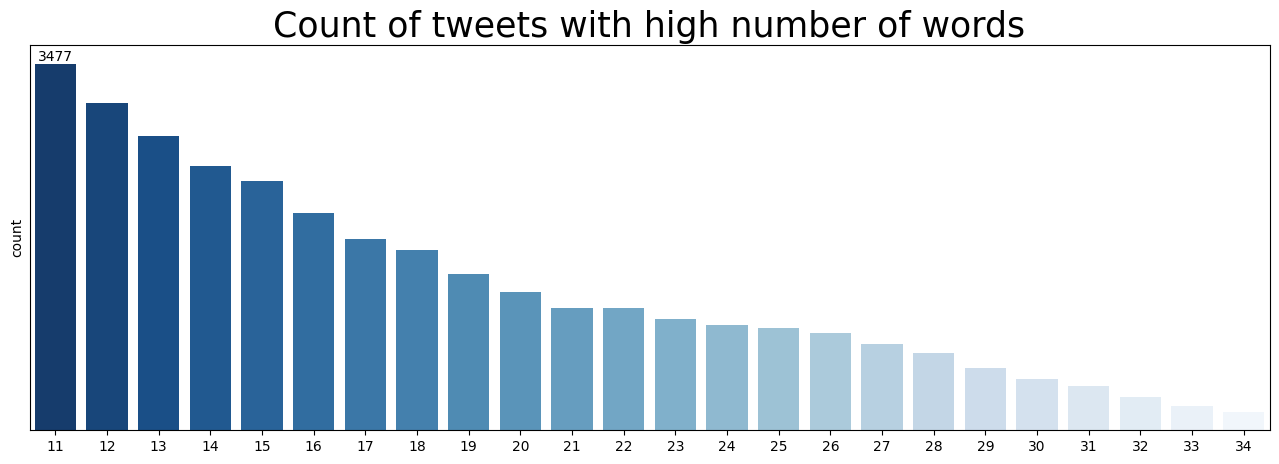

In [18]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='tweet_len', data=df[(df['tweet_len']<=1000) & (df['tweet_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

## Обучаем модели

In [19]:
MAX_LEN = int(df['tweet_len'].quantile(0.95))

In [20]:
def lstm_prep(column , seq_len) :
    # create a vocab of words
    corpus = [word for text in column for word in text.split()]
    words_count = Counter(corpus)
    sorted_words = words_count.most_common()
    vocab_to_int = {w:i+1 for i , (w,c) in enumerate(sorted_words)}

    text_int = []

    for text in column :
        token = [vocab_to_int[word] for word in text.split()]
        text_int.append(token)


    # padding
    features = np.zeros((len(text_int) , seq_len) , dtype = int)
    for idx , y in tqdm(enumerate(text_int)) :
        if len(y) <= seq_len :
            zeros = list(np.zeros(seq_len - len(y)))
            new = zeros + y

        else :
            new = y[:seq_len]

        features[idx,:] = np.array(new)

    return sorted_words, features

In [21]:
VOCAB , tokenized_column = lstm_prep(df['cleaned_tweets'] , MAX_LEN)

0it [00:00, ?it/s]

In [22]:
VOCAB[:10]

[('game', 9936),
 ('play', 6265),
 ('get', 5134),
 ('like', 4734),
 ('im', 4408),
 ('facebook', 3893),
 ('googl', 3839),
 ('microsoft', 3836),
 ('amazon', 3830),
 ('verizon', 3751)]

In [23]:
tokenized_column.shape

(61376, 27)

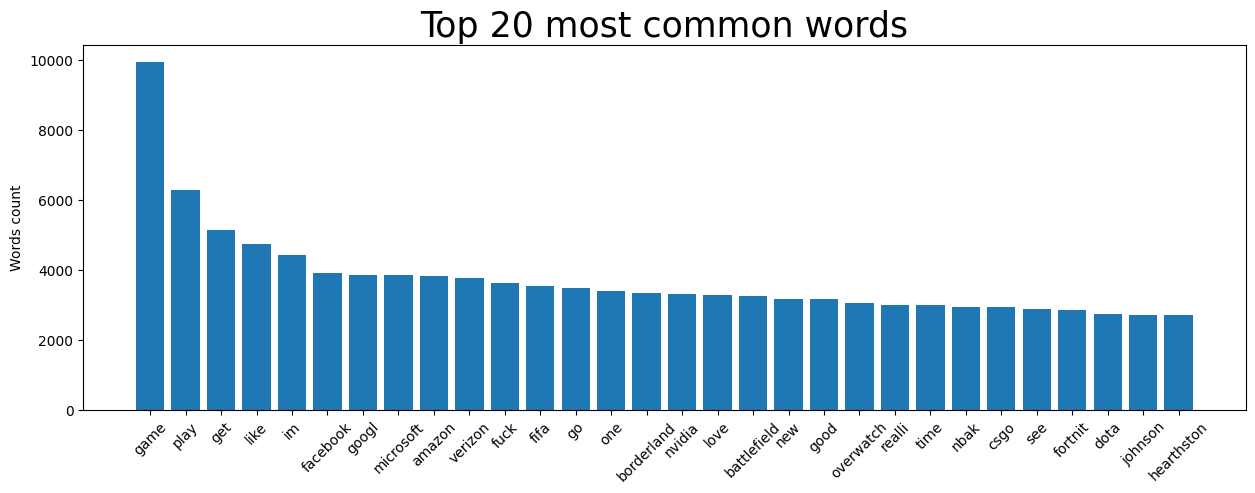

In [24]:
def most_common_words(vocab) :
    keys = []
    values = []
    for key , value in vocab[:30] :
        keys.append(key)
        values.append(value)

    plt.figure(figsize=(15, 5))
    ax = plt.bar(keys, values)
    plt.title('Top 20 most common words', size=25)
    plt.ylabel("Words count")
    plt.xticks(rotation=45)
    plt.subplots_adjust(bottom=0.15)
    plt.show()

most_common_words(VOCAB)

In [25]:
X = tokenized_column
y = lb.fit_transform(df['labels'].values)

In [26]:
X_train , X_val , Y_train , Y_val = train_test_split(X , y , train_size=0.85 , random_state=42)

In [27]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.LongTensor(Y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.LongTensor(Y_val))

In [28]:
BATCH_SIZE = 64
train_dataloader = DataLoader(
    dataset = train_data ,
    batch_size=BATCH_SIZE ,
    shuffle=True
)
val_dataloader = DataLoader(
    dataset = val_data ,
    batch_size = BATCH_SIZE ,
    shuffle=False
)

In [29]:
EMBEDDING_DIM = 200

In [30]:
Word2vec_train_data = list(map(lambda x: x.split(), df['cleaned_tweets']))
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)

In [31]:
def weight_matrix(model,vocab):
    vocab_size= len(vocab)+1
    embedding_matrix = np.zeros((vocab_size,EMBEDDING_DIM))
    for word, token in vocab:
        if model.wv.__contains__(word):
            embedding_matrix[token]=model.wv.__getitem__(word)
    return embedding_matrix

In [32]:
embedding_vec = weight_matrix(word2vec_model,VOCAB)
print("Embedding Matrix Shape:", embedding_vec.shape)

Embedding Matrix Shape: (29811, 200)


In [33]:
def param_count(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print('The Total number of parameters in the model : ', sum(params))

In [34]:
class Model(nn.Module) :
    def __init__(self , vocab_size , embedding_dim
                 , num_layers , hidden_dim , out_channels , bidirectional, device='cpu') :
        super().__init__()
        print(device)
        self.no_layers = num_layers
        self.hidden_dim = hidden_dim
        self.out_channels = out_channels
        self.num_directions = 2 if bidirectional else 1
        self.embedding = nn.Embedding(vocab_size , embedding_dim)
        self.embedding = self.embedding.to(device)
        self.device = device
        self.lstm = nn.LSTM(
            embedding_dim ,
            hidden_dim ,
            num_layers ,
            dropout = 0.5 ,
            bidirectional = bidirectional ,
            batch_first = True
        )
        self.lstm = self.lstm.to(device)

        self.fc = nn.Linear(hidden_dim*self.num_directions , out_channels)
        self.fc = self.fc.to(device)


    def forward(self , x) :
        h0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim)).to(self.device)
        c0 = torch.zeros((self.no_layers * self.num_directions , x.size(0) , self.hidden_dim)).to(self.device)

        embedded = self.embedding(x)

        out , _ = self.lstm(embedded , (h0 , c0))

        out = out[:,-1,:]

        out = self.fc(out)

        return out

In [35]:
VOCAB_SIZE = len(VOCAB) + 1
NUM_LAYERS = 2
OUT_CHANNELS = 4
HIDDEN_DIM = 256
BIDIRECTIONAL = True
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Model(VOCAB_SIZE , EMBEDDING_DIM , NUM_LAYERS , HIDDEN_DIM , OUT_CHANNELS , BIDIRECTIONAL, DEVICE)

model.embedding.weight.data.copy_(torch.from_numpy(embedding_vec))

model.embedding.weight.requires_grad = True

if torch.cuda.is_available():
    model = model.cuda()

cpu


In [36]:
param_count(model)

The Total number of parameters in the model :  8479196


In [37]:
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion=nn.CrossEntropyLoss()
optimizer=Adam(model.parameters(),lr=0.001)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

epochs = 10
training_loss = []
training_acc = []
best_loss = float('inf')
patience = 3
patience_counter = 0
for i in tqdm(range(epochs)) :
    epoch_loss = 0
    epoch_acc = 0
    for batch , (x_train , y_train) in enumerate(train_dataloader) :
        x_train , y_train = x_train.to(DEVICE), y_train.to(DEVICE)
        y_pred = model(x_train)

        loss = criterion(y_pred , y_train)

        if batch % 500 == 0:
            print(f"Looked at {batch * len(x_train)}/{len(train_dataloader.dataset)} samples.")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss +=loss
        epoch_acc += accuracy_score(y_train.cpu() , y_pred.argmax(dim=1).cpu())

    training_loss.append((epoch_loss/len(train_dataloader)).detach().cpu().numpy())
    training_acc.append(epoch_acc/len(train_dataloader))

    scheduler.step()

    print(f"Epoch {i+1}: Accuracy: {(epoch_acc/len(train_dataloader)) * 100}, Loss: {(epoch_loss/len(train_dataloader))}\n\n")

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

  0%|          | 0/10 [00:00<?, ?it/s]

Looked at 0/52169 samples.
Looked at 32000/52169 samples.
Epoch 1: Accuracy: 60.12518722766884, Loss: 0.9601382613182068


Looked at 0/52169 samples.
Looked at 32000/52169 samples.
Epoch 2: Accuracy: 84.36308551198258, Loss: 0.44261860847473145


Looked at 0/52169 samples.
Looked at 32000/52169 samples.
Epoch 3: Accuracy: 90.9390318627451, Loss: 0.25972801446914673


Looked at 0/52169 samples.
Looked at 32000/52169 samples.
Epoch 4: Accuracy: 93.46660539215686, Loss: 0.18196101486682892


Looked at 0/52169 samples.
Looked at 32000/52169 samples.
Epoch 5: Accuracy: 95.19761029411765, Loss: 0.13426192104816437


Looked at 0/52169 samples.
Looked at 32000/52169 samples.
Epoch 6: Accuracy: 96.39799496187365, Loss: 0.10086048394441605


Looked at 0/52169 samples.
Looked at 32000/52169 samples.
Epoch 7: Accuracy: 97.25413602941177, Loss: 0.07690998911857605


Looked at 0/52169 samples.
Looked at 32000/52169 samples.
Epoch 8: Accuracy: 97.82858455882352, Loss: 0.05941346660256386


Looked at 

## Время Prediction

In [38]:
test_df = pd.read_csv('twitter_validation.csv', header=None)
print(test_df.head())
test_df = test_df.drop(0 , axis=1)

test_df = test_df.rename(columns={1:"Feature2",3:"Feature1",2: "labels"})
test_df.head()

      0          1           2  \
0  3364   Facebook  Irrelevant   
1   352     Amazon     Neutral   
2  8312  Microsoft    Negative   
3  4371      CS-GO    Negative   
4  4433     Google     Neutral   

                                                   3  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - Amazon boss Jeff Bezos rejects clai...  
2  @Microsoft Why do I pay for WORD when it funct...  
3  CSGO matchmaking is so full of closet hacking,...  
4  Now the President is slapping Americans in the...  


,Feature2,labels,Feature1
0,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Google,Neutral,Now the President is slapping Americans in the...


In [39]:
test_df["tweets"]= test_df["Feature1"].astype(str) +" "+ test_df["Feature2"].astype(str)
test_df= test_df.drop(["Feature1","Feature2"],axis=1)

In [40]:
test_df.head()

,labels,tweets
0,Irrelevant,I mentioned on Facebook that I was struggling ...
1,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,Negative,@Microsoft Why do I pay for WORD when it funct...
3,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,Neutral,Now the President is slapping Americans in the...


In [50]:
vec = TfidfVectorizer(max_features=5000)
vec.fit(df['cleaned_tweets'])

def make_predictions(row) :
    random_data = row.sample(n=10)
    random_tweets = random_data['tweets'].values

    cleaned_tweets = []
    for tweet in random_tweets :
        cleaned_tweets.append(DataPrep(tweet))

    x_test = vec.transform(cleaned_tweets).toarray()

    y_test = random_data['labels'].values

    _ , X_test = lstm_prep(cleaned_tweets , MAX_LEN)

    X_test = torch.from_numpy(X_test).to(DEVICE)

    lstm_pred = model(X_test)
    lstm_pred = torch.softmax(lstm_pred , dim=1 ).argmax(dim=1)
    pred = np.array([getlabel(lstm_pred[i]) for i in range(len(lstm_pred))])
    for i in tqdm(range(2)) :
        print(f"The original tweet : {random_tweets[i]}\n")
        print(f"The original label : {y_test[i]}\n")
        print(f"The lstm prediction is : {getlabel(lstm_pred[i])}\n")
        print('-'*120)
    print(accuracy_score(pred, y_test))


make_predictions(test_df)

0it [00:00, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

The original tweet : Red Dead Redemption 2
@RockstarGames
#RDR2 #RedDeadOnline 
#OutlawsForLife 
#PS4share pic.twitter.com/QHk7zNRwM8 RedDeadRedemption(RDR)

The original label : Neutral

The lstm prediction is : Positive

------------------------------------------------------------------------------------------------------------------------
The original tweet : That’s the best one wtf? AssassinsCreed

The original label : Positive

The lstm prediction is : Positive

------------------------------------------------------------------------------------------------------------------------
0.7
